#Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
import re

# Data Preprocessing

In [2]:
train_data = pd.read_csv('train.csv', index_col='id')

new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in train_data.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
train_data = train_data.rename(columns=new_names)

def fe(df):
    df_new = df.copy()
    df_new["HardAnion"] = (df_new["Calcium"] + df_new["Magnesium"]) / df_new["TotalDissolvedSolids"]
    df_new["SoftAnion"] = df_new["Sodium"] / df_new["TotalDissolvedSolids"]
    df_new["TotalCation"] = (df_new["Chloride"] + df_new["Fluoride"] + df_new["NitrateasN"] + df_new["Sulfate"]) / df_new["TotalDissolvedSolids"]
    return df_new

train_data_fe = fe(train_data)

features = train_data_fe.drop(columns=["Calcium", "Magnesium", "Sodium", "Chloride", "Fluoride", "NitrateasN", "Sulfate", 'Hardness', 'TotalDissolvedSolids'])
target = train_data_fe['Hardness']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, random_state=69420, test_size=0.1)

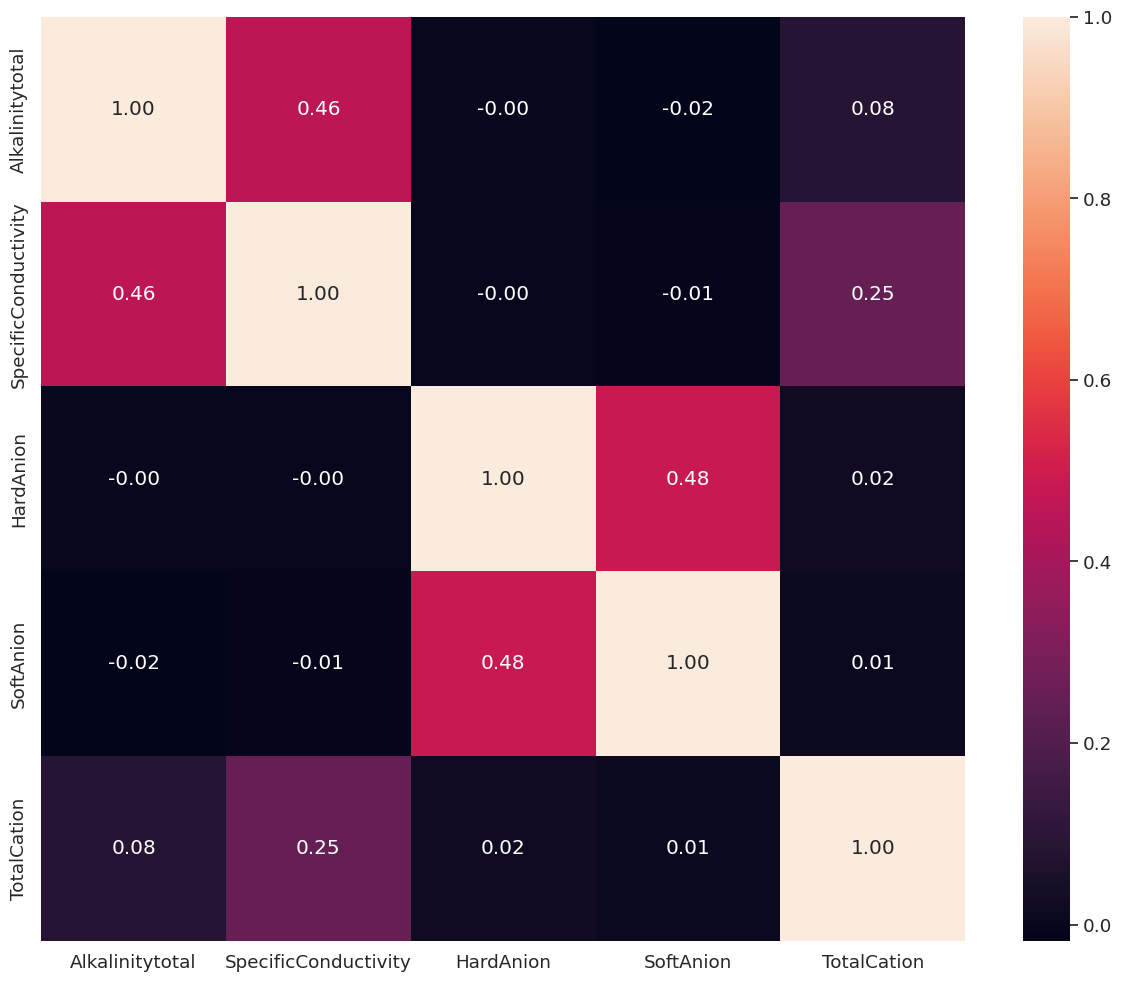

                feature       VIF
0       Alkalinitytotal  2.940159
1  SpecificConductivity  2.872353
2             HardAnion  1.317641
3             SoftAnion  1.312863
4           TotalCation  1.758258


In [3]:
columns = features.columns
correlation_map = np.corrcoef(features[columns].values.T)
plt.figure(figsize=(15, 12))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
print(vif_data)

In [4]:
scaler = preprocessing.StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

# Modelling

In [14]:
train_data_lgb = lgb.Dataset(X_train, label=Y_train)
test_data_lgb = lgb.Dataset(X_val, label=Y_val, reference=train_data_lgb)

params = {
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'num_leaves': [15, 20, 26, 31, 47, 63],
    'learning_rate': [0.01, 0.015, 0.02, 0.025, 0.05, 0.1],
    'feature_fraction': [1.0, 0.9, 0.8],
    'seed': [69420]
}

lgb_regressor = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=params, scoring='r2', cv=5)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(best_params)

num_round = 500
bst = lgb.train(best_params,
                train_data_lgb,
                num_boost_round=500,
                valid_sets=[test_data_lgb])

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, Y_train)

y_train = best_model.predict(X_train)
y_val = best_model.predict(X_val)

print("Training R2: ", r2_score(Y_train, y_train))
print("Validation R2: ", r2_score(Y_val, y_val))

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 4608, number of used features: 5
[LightGBM] [Info] Start training from score 217.488345
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wi

In [15]:
test_data = pd.read_csv('test.csv', index_col='id')
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in test_data.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
test_data = test_data.rename(columns=new_names)

test_data_fe = fe(test_data)
X_test = test_data_fe.drop(columns=["Calcium", "Magnesium", "Sodium", "Chloride", "Fluoride", "NitrateasN", "Sulfate", "TotalDissolvedSolids"])

predictions = best_model.predict(X_test)

submission_ids = range(6400, 6400 + len(test_data))
submission = pd.DataFrame({'id': submission_ids, 'Hardness': predictions})

submission.to_csv('submission.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
